# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer Vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing the car in front.

## Get the data

The Image we're working with are from the Food101 dataset (101 different classes of food) : [data set](https://www.kaggle.com/datasets/dansbecker/food-101)

however we'vw modified it to only use two classes(pizza 🍕 & steak 🍖) using image data modification notebook.

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

> 🔑 **Note:** we start with a samller dataset so we can experiment quickly and figure what works better.

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2023-09-27 18:37:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.195.187, 142.250.182.59, 142.250.193.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.195.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   676KB/s    in 65s     

2023-09-27 18:38:22 (1.61 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [2]:
# Unzip
zip_ref=zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall(path='./data/')
zip_ref.close()

## Inspect the data (become one with data)

A very crucial step at the beginning of any ml project is becoming one with data.

And for a computer vision project.. this is usually means visualizig many smaple of your  data.

In [4]:
!ls pizza_steak

test  train


In [7]:
!ls pizza_steak/train/pizza

1008104.jpg  1638227.jpg  2235981.jpg  2774899.jpg  3464027.jpg  576236.jpg
1008144.jpg  1646974.jpg  2236914.jpg  2775763.jpg  3464858.jpg  5764.jpg
1008844.jpg  1649108.jpg  2241448.jpg  2778214.jpg  3473991.jpg  579691.jpg
1008941.jpg  1649276.jpg  2247711.jpg  277963.jpg   3475936.jpg  593400.jpg
1011404.jpg  1652943.jpg  2253670.jpg  2785084.jpg  3478964.jpg  59445.jpg
102037.jpg   1654444.jpg  2255361.jpg  2793535.jpg  3479875.jpg  596494.jpg
1026922.jpg  1660415.jpg  2274117.jpg  27963.jpg    3479936.jpg  598381.jpg
1029698.jpg  1663749.jpg  2279642.jpg  2800325.jpg  3484590.jpg  604977.jpg
1033251.jpg  1665654.jpg  2280345.jpg  2811032.jpg  3493457.jpg  608085.jpg
1035854.jpg  166823.jpg   2285269.jpg  282013.jpg   349946.jpg	 618021.jpg
1038357.jpg  1670471.jpg  2285942.jpg  2821034.jpg  350358.jpg	 61822.jpg
1040878.jpg  1671531.jpg  228778.jpg   2821048.jpg  3505182.jpg  618348.jpg
1044524.jpg  1678284.jpg  2291093.jpg  2827938.jpg  3512070.jpg  625687.jpg
1044789.jpg  16810

In [4]:
import os

# walk through  the pizza_steak

for dirpath,dirnames,filenames in os.walk("data/pizza_steak"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

there are 2 directories and 0 files in data/pizza_steak
there are 2 directories and 0 files in data/pizza_steak/test
there are 0 directories and 250 files in data/pizza_steak/test/pizza
there are 0 directories and 250 files in data/pizza_steak/test/steak
there are 2 directories and 0 files in data/pizza_steak/train
there are 0 directories and 750 files in data/pizza_steak/train/pizza
there are 0 directories and 750 files in data/pizza_steak/train/steak


To Visualize our image, first let's get he class names programmatically

In [5]:
import pathlib
import numpy as np

data_dir=pathlib.Path("data/pizza_steak/train")

class_names=np.array(sorted([item.name for item in data_dir.glob("*")]))


print(class_names)


['pizza' 'steak']


In [7]:
# Let's visualize our image
import matplotlib.pyplot as plt
import matplotlib.image as mping
import random

def view_random_image(target_dir,target_class):
  target_folder=target_dir+target_class

  random_image=random.sample(os.listdir(target_folder),1)

  # read in the image and plot it using matplotlib

  img=mping.imread(target_folder+"/"+random_image[0])

  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"the shape of the image is {img.shape}") # show the shape of the image



the shape of the image is (384, 512, 3)


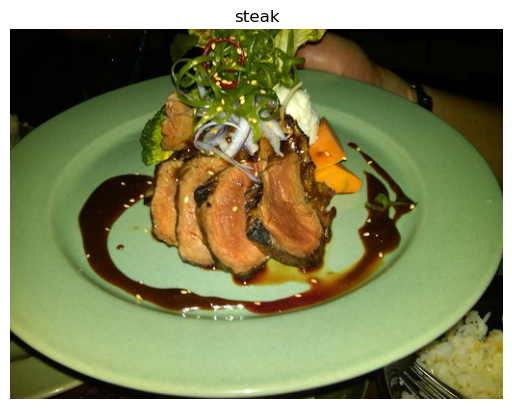

In [8]:
view_random_image("data/pizza_steak/train/","steak")

> 🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255. (since 255 is the maximum pixel value).

## An end-to-end example

Let's build a convolutional neural network to find patterns in our images, more specifically we a need way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [9]:
 # import tensorflow

import tensorflow as tf
import tensorflow_hub as hub

print("Tenserflow version",tf.__version__)
print("Tenserflow Hub version",hub.__version__)

# check GPU
print("GPU" ,"Available (Yes)" if tf.config.list_physical_devices("GPU") else "Not Available 😢")

Tenserflow version 2.12.0
Tenserflow Hub version 0.14.0
GPU Available (Yes)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1.set random seed

tf.random.set_seed(42)

# preprocess data (get all of the pixel values b/w 0 & 1)

train_datagen=ImageDataGenerator(rescale=1./225)
valid_datagen=ImageDataGenerator(rescale=1./225)


# set paths
train_dir="data/pizza_steak/train"
test_dir="data/pizza_steak/test"

# import the data from dir

train_data=train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(224,224),class_mode="binary",seed=42)

valid_data=valid_datagen.flow_from_directory(test_dir,batch_size=32,target_size=(224,224),class_mode="binary",seed=42)

# 2.bulid the model (same as Tiny VGG)

model_1=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224,224,3) # resize the image to [224,224,3] shape
                           ),
    tf.keras.layers.Conv2D(10,3,activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,padding="valid"),
    tf.keras.layers.Conv2D(10,3,activation="relu"),
    tf.keras.layers.Conv2D(10,3,activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(), # flatten the image
    tf.keras.layers.Dense(1,activation="sigmoid")
])

# 3.compile the model

model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# 4.build the model

history_1=model_1.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data), # 47 image per batch
                      validation_data=valid_data,
                      validation_steps=len(valid_data)
                      )


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Epoch 1/5


2023-09-27 18:49:35.263179: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


47/47 [==============================] - 80s 2s/step - loss: 0.6393 - accuracy: 0.6420 - val_loss: 0.5970 - val_accuracy: 0.6860
Epoch 2/5
47/47 [==============================] - 82s 2s/step - loss: 0.5186 - accuracy: 0.7507 - val_loss: 0.4013 - val_accuracy: 0.8180
Epoch 3/5
47/47 [==============================] - 73s 2s/step - loss: 0.4509 - accuracy: 0.7953 - val_loss: 0.3479 - val_accuracy: 0.8580
Epoch 4/5
47/47 [==============================] - 68s 1s/step - loss: 0.3783 - accuracy: 0.8387 - val_loss: 0.3329 - val_accuracy: 0.8620
Epoch 5/5
47/47 [==============================] - 64s 1s/step - loss: 0.3526 - accuracy: 0.8453 - val_loss: 0.3413 - val_accuracy: 0.8560


In [37]:
train_data.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

> 🔑 Note: You can think of trainable parameters as **patterns a model can learn from data**. Intuitively, you might think more is better. And in lots of cases, it is. But in this case, the difference here is the two different styles of model we're using. Where a series of dense layers has a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a convolutional neural network seeks to sort out and learn the most important patterns in an image**. So even though these are less learnable parameters in our convolutional neural network, these are often more helpful in dechiphering between different features in an image.

## Binary Classification : Let's break it down

1. Become one with the data (visualize,visualize,visualize)
2. Preprocess the data (prepared it for our model, do scaling/normalizing)
3. Created a model (start with baseline)
4. Fit the model
5. Evalue the model
6. Adjust the different paramaters and improve the model (try untill u get the best result)
7. Repeat untill satisfied (experiment,experiment,experiment)

In [1]:
# visualize data

plt.figure(figsize=(10,10))
for i in range(1,10):
  plt.subplot(5,2,i) # row , col , sub plot
  steak_image=view_random_image("pizza_steak/train/","steak")
  plt.subplot(5,2,i+1)

  pizza_image=view_random_image("pizza_steak/train/","pizza")


NameError: name 'plt' is not defined

### 2.Preprocess the data (prepare it for a model)


In [ ]:
# set paths
train_dir="/content/pizza_steak/train"
test_dir="/content/pizza_steak/test"


Our next step is to turn our data into **bataches**

A batch is small subset of data. Rather than look at all ~10,000
images at a time , a model might only look at 32 image at a time.

we do it for couple of reasons:
1. 10,000 images might not fit into our memory `(GPU)`
2. Trying to learn the pattern from 10,000 is one hit could make the result of the model not well.


Resources:
1.[ImageDataGen](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)



In [2]:
# create train and test data generators and rescale the data


from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1/225.) # rescale all the pixel to 255
test_datagen=ImageDataGenerator(rescale=1/225.) # rescale all the pixel to 255

In [ ]:
from traitlets.traitlets import directional_link
# load in our iamge data from directories and turn them into bateches

train_data=train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224,224),
    class_mode="binary",
    batch_size=32
)


valid_data=test_datagen.flow_from_directory(
    directory=test_dir, # target dir
    target_size=(224,224), # Target size of the image
    class_mode="binary", # type of data you're working with
    batch_size=32 # size of minibatches to load data into
)




In [ ]:
# get a sample of train data batch

image,labels=train_data.next() # get the next batch of image/label in train data

len(image),len(labels)

### 3. Create a CNN model (start with a baseline)

A baseline is a realtively a simple model or existing result that you setup when beginning a machine learning experiment and then you experimenting to improve it

> 🔑 **Note:** In deep learning, there is almost an infinite amount of architectures you could create. so one of the best way to get started something and see if it works on your data and then introduce complexity as required

In [ ]:
# import required things
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten
from tensorflow.keras import Sequential

# 1.create the model (this will be our base line)
model_4=Sequential([
    Conv2D(
        filters=10, # no of sliding window going across I/P
        kernel_size=3, # size of the sliding window
        padding="valid", # adding blank pixel around the border [if "same" , output shape same as input shale else "valid", then ouptshape is compressed]
        strides=1, # the size of the step that slind window take in I/P
        activation="relu",
        input_shape=(224,224,3)
    ),# input later
    Conv2D(10,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    Flatten(),
    Dense(1,activation="sigmoid") # output later 

])

#2. compile the model

model_4.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=Adam(),
    metrics=['accuracy']
)




## 3. fit the model


In [ ]:
model_4.summary()

In [ ]:
# fit the model
history_4=model_4.fit(
    train_data, # it has both label,image
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data),
)
